# Learning Rate Finder
> Approximate to the optimal learning rate quickly without costly searches

- toc: true
- badges: true
- author: Austin Chen
- categories: [optimizer,learning rate]

The learning rate is arguably the most important hyperparameter that controls how much we are adjusting the weights of our network with respect to the loss gradient. It stands for how much a model can ***learn*** from a new mini-batch of training data. The higher the learning rate, the bigger the steps we take along the trajectory to the minimum of the loss function, where the best model parameters are.

![](https://blog.dataiku.com/hs-fs/hubfs/dftt1.png?width=1200&name=dftt1.png)



## Why is it hard?

The learning rate is a tricky hyperparameter to tune for a number of reasons:
- In most cases, domain knowledge or previous studies are of little help, for a learning rate that worked well for one problem might not be even half as good for another, even a closely-related one.
- Tuning learning rates via a grid search or a random search is typically costly, both in terms of time and computing power, especially for large networks.
- The optimal learning rate is tightly coupled with other hyperparameters. Hence, each time your change the amount of regularization or the networks architecture, you should re-tune the learning rate.


In [2]:
#collapse-hide
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
import os, gc, cv2, random, warnings
import math, sys, json, pprint, pdb

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split

warnings.simplefilter('ignore')
print(f"Using TensorFlow v{tf.__version__}")

Using TensorFlow v2.4.0


In [3]:
#hide
#@title Accelerator { run: "auto" }
DEVICE = 'GPU' #@param ["None", "'GPU'", "'TPU'"] {type:"raw", allow-input: true}

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTOTUNE = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using default strategy for CPU and single GPU
Num GPUs Available:  1
REPLICAS: 1


In [4]:
#hide
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

GOOGLE = 'google.colab' in str(get_ipython())
KAGGLE = not GOOGLE

print("Running on {}!".format(
   "Google Colab" if GOOGLE else "Kaggle Kernel"
))

Running on Google Colab!


In [5]:
#hide
SEED = 16
seed_everything(SEED)

## Implement `LRFinder`

In [6]:
class MultiplicativeLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.losses = []
        self.lrs = []

    def on_train_batch_end(self, batch, logs):
        self.lrs.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr*self.factor)

Text(0.5, 0, 'iteration')

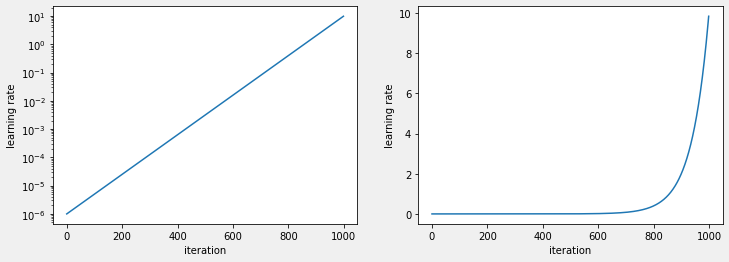

In [7]:
min_lr = 1e-6
max_lr = 1e1
num_iter = 1000

lr_factor = np.exp(np.log(max_lr / min_lr) / num_iter)
lrs = [min_lr * (lr_factor)**i for i in range(num_iter)]

fig,axs = plt.subplots(1,2,figsize=(12,4),facecolor="#F0F0F0")
axs[0].plot(lrs)
axs[0].set_yscale("log")
axs[0].set_ylabel("learning rate")
axs[0].set_xlabel("iteration")

axs[1].plot(lrs)
axs[1].set_ylabel("learning rate")
axs[1].set_xlabel("iteration")

In [8]:
def find_lr(model, x, y, batch_size, min_lr=1e-6, max_lr=1e1):
    num_iter = len(x) // batch_size
    lr_factor = np.exp(np.log(max_lr / min_lr) / num_iter)

    K.set_value(model.optimizer.lr, min_lr)
    lr_callback = MultiplicativeLearningRate(lr_factor)
    lrs = [min_lr * (lr_factor)**i for i in range(num_iter)]


In [ ]:
class LRFinder(Callback):
    """Callback that exponentially adjusts the learning rate after each
    training batch between start_lr and end_lr for a maximum number of 
    batches: max_step. The loss and learning rate are recorded at each
    step allowing visually finding a good learning rate as per 
    https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html
    via the plot method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10,
                 max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1,1,facecolor="#F0F0F0")
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

## Load MNIST dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


## Pre-processing

In [ ]:
IMG_SIZE = (28, 28, 1)
NCLASSES = 10

In [ ]:
x_train = np.expand_dims(x_train.astype('float32') / 255.0, axis=-1)
x_test = np.expand_dims(x_test.astype('float32') / 255.0, axis=-1)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, NCLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NCLASSES)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (60000, 10)
y_test shape: (10000, 10)


## Build a model

In [ ]:
def build_simple_model(input_shape, lr=None):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                     input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    
    opt = tf.keras.optimizers.Adam(learning_rate=lr if lr else 1e-3)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [ ]:
BATCH_SIZE = 32
EPOCHS = 6
STEPS = len(x_train) // BATCH_SIZE

## Train without finding optimal lr

Let us train our model without searching for an optimal learning rate. We will be using the default learning rate for the optimizer

In [ ]:
model = build_simple_model(IMG_SIZE)
model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3609 - accuracy: 0.8875
Epoch 2/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0859 - accuracy: 0.9743
Epoch 3/6
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0551 - accuracy: 0.9825
Epoch 4/6
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0504 - accuracy: 0.9844
Epoch 5/6
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0398 - accuracy: 0.9878
Epoch 6/6
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0354 - accuracy: 0.9885


In [ ]:
score = model.evaluate(x_test, y_test, verbose=0,batch_size=BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03285309299826622
Test accuracy: 0.9901000261306763


## Train with the optimal initial lr

We will create an instance of the class we built above and pass it as a callback to our model. The LR finder is very cheap in terms of compute and it hardly takes an epoch or less to complete. We will keep the default values of `base_lr` and `max_lr` but you can change it if you want to. 

In [ ]:
lr_finder = LRFinder(max_steps=1000)
model2 = build_simple_model(IMG_SIZE)
_ = model2.fit(x_train, y_train, epochs=EPOCHS, 
               batch_size=BATCH_SIZE, verbose=0,
               callbacks=[lr_finder])

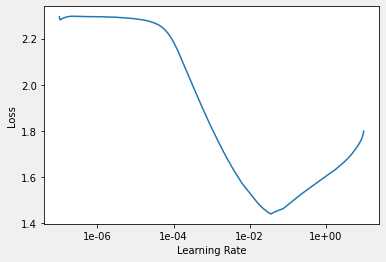

In [ ]:
lr_finder.plot()

Let's train the model with the optimal lr found using LR finder

In [ ]:
model3 = build_simple_model(IMG_SIZE, lr=3e-3)
model3.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2942 - accuracy: 0.9101
Epoch 2/6
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0943 - accuracy: 0.9716
Epoch 3/6
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0697 - accuracy: 0.9793
Epoch 4/6
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0616 - accuracy: 0.9808
Epoch 5/6
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0510 - accuracy: 0.9843
Epoch 6/6
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0519 - accuracy: 0.9849


In [ ]:
# Evaluate
score = model3.evaluate(x_test, y_test, verbose=0, batch_size=BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.029018929228186607
Test accuracy: 0.9915000200271606


You can see that if we start with an optimal learning rate, we can coverge much faster. A good start always pays off! 

## Conclusion

In this notebook, we saw how we can implement a simple `LR finder` in keras. Keras gives you the hooks to implement almost anything seamlessly. Before writing anything from scratch, you should always check how can you use a hook to implement it in Keras first.

## References
* https://arxiv.org/abs/1708.07120
* https://arxiv.org/abs/1506.01186
* https://arxiv.org/abs/1803.09820
* https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

## 1% Better Everyday

Maybe we don't really need to create a class for learning rate finder. Perhaps we can achieve the same goal by using the [`tf.keras.optimizers.schedules.ExponentialDecay`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay) plus tensor board.

- https://blog.dataiku.com/the-learning-rate-finder-technique-how-reliable-is-it
- https://medium.com/octavian-ai/how-to-use-the-learning-rate-finder-in-tensorflow-126210de9489
